In [21]:
import numpy as np
class lattice:
    """
    REQUIRES : import numpy as np
    INPUT : 
        Grid size : L0 -> self.L
        Free cell probability : pf
    MIDDLE OUTPUT
        FREE_GRID : path to follow
    OUTPUT
        GRID / NEW_GRID; edge / edgeB, edgeU, edgeD, edgeL, edgeR; conv; STEP; density()
        ? fractaldimension : outside function that uses self.toplot()
    DESCRIPTION
        * We use a GRID with size (L+2)^2. The border of the GRID is neglected.
            Input and Output does not seem the "extra" size
        * Comment: 
            It is assumed that the border is fully free. 
            at some moment we can explore some boundary condition
        * To simplify we use odd L, so that the grid center is well defined
        
    """   
    def __init__(self,L0,pf):
        if (L0%2) : self.L = L0
        else :
            self.L = L0+1
            print("Size changed to "+str(L0+1))
        
        self.GRID = np.zeros((self.L+2,self.L+2),dtype=bool)    
        Lm=np.int((self.L+1)/2)        
        self.GRID[Lm,Lm]=True
        
        INIT_RAND = np.random.rand(self.L,self.L)
        self.FREE_GRID = np.zeros((self.L+2,self.L+2),dtype=bool)    
        self.FREE_GRID[1:-1,1:-1] = (INIT_RAND < pf) #True se vazio
        self.FREE_GRID[Lm,Lm]=True

        self.edgeU=False
        self.edgeD=False
        self.edgeL=False
        self.edgeR=False
        self.edge=False
        self.conv=False
        self.STEP=0
        return
    def toprint(self):
        return self.GRID[1:-1,1:-1]*1 + np.invert(self.FREE_GRID[1:-1,1:-1])*(-1)
    def nextstep(self):
        """ Método sem condição de contorno periodica. Bordas são ignoradas"""
        self.NEW_GRID = self.GRID.copy()
        hasOne = (self.GRID[0:-2,1:-1] + self.GRID[1:-1,0:-2] + 
                  self.GRID[1:-1,2:] + self.GRID[2:  ,1:-1])
        self.NEW_GRID[1:-1,1:-1] = self.GRID[1:-1,1:-1] + self.FREE_GRID[1:-1,1:-1]*hasOne
        return
    def acept(self):
        self.GRID = self.NEW_GRID
        return
    def checkedge(self):
        """ GRID with size self.L+2
            index 0 and L+1 are null borders
            index 1 and L are true edges
        """
        self.edgeU = 1 in self.GRID[1]
        self.edgeD = 1 in self.GRID[self.L]
        self.edgeL = 1 in self.GRID.T[1]
        self.edgeR = 1 in self.GRID.T[self.L]
        self.edge = self.edgeU + self.edgeD + self.edgeL + self.edgeR
        self.edgeB = np.bool(self.edge)
        return 
    def checkconvergence(self):
        self.conv = False not in (self.GRID == self.NEW_GRID)
        return
    def percolate(self):
        MAX_STEPS = 1000
        while (self.STEP < MAX_STEPS):
            self.nextstep()
            self.checkedge()
            self.checkconvergence()
            if self.conv : break
            if self.edge : break
            self.acept()
            self.STEP +=1
        return
    def evolve(self,N):
        for i in range(N):
            self.nextstep()
            self.acept()
            self.STEP +=1
        return
    def density(self):
        return self.GRID.sum() / (self.L*self.L)


In [22]:
x = lattice(5,.5)
x.percolate()
x.toprint()

array([[-1,  0,  0,  0,  0],
       [-1, -1, -1, -1, -1],
       [ 1,  1,  1, -1,  0],
       [-1, -1,  1, -1, -1],
       [-1,  0, -1,  0,  0]])

In [23]:
from matplotlib import pyplot as plt
def plot(toprint):
    plt.figure()
    plt.imshow(toprint,vmin=-1,vmax=1,cmap='coolwarm')
    plt.axis('off')
    return

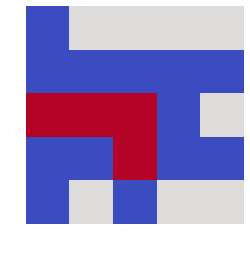

In [26]:
plot(x.toprint())

In [27]:
def average_main(L,pf,samples,kind):
    """A diferença do kind é na escolha do Return na função main()
        Isso significa, aqui, a escolha do que estamos tomando a média no número
        de samples. """
        
    if ((kind == 'A') or (kind=='B') or (kind=='E')): average=0
    elif ((kind == 'C') or (kind=='D')): average=np.zeros(4)
    
    for it in range(samples):
        x = lattice(L,pf)
        x.percolate()
        if (kind=='A'): average += x.edgeB
        elif (kind=='B'): average += x.density()
        elif (kind=='C'): average += [x.edgeU,x.edgeD,x.edgeL,x.edgeR]
        elif ((kind=='D') and (x.edge>0)): average[x.edge-1] += 1
        elif (kind=='E') : average += fractal_dimension(x.toprint())
    average /= samples
    
    return average

In [35]:
from matplotlib import pyplot as plt
from pylab import matplotlib as mpl
from scipy.optimize import curve_fit
mpl.rcParams.update({'font.size': 18, 'font.family': 'serif'})
import time

def runover_main(L,samples,prob_points,kind,FlagFit,FlagPlot):
    """ average_main ao longo de um intervalo de valores de probabilidade
    """
    TheMethod = ['Grid Copies', 'Border Expansion','Grid Copies with Bits']
    method=0
    if (kind=='A'): thestrings = ['Percolation','Frequency']
    elif (kind=='B'): thestrings = ['Density','Mean Density']
    elif (kind=='C'): 
        thestrings = ['PercWhich','Frequency']
        thelabels = ['up','down','left','right']
    elif (kind=='D'): 
        thestrings = ['PercMany','Frequency']
        thelabels = ['1 wall','2 walls','3 walls','4 walls']
    elif (kind=='E'): 
        thestrings = ['FractalDim','Fractal Dimension']
        thelabels = ['1 wall','2 walls','3 walls','4 walls']        
        
    if FlagFit : #PROIBINDO CONTINUAR IMPLEMENTAÇÃO NO CASO NÃO PREPARADO
        if kind is not 'A' : 
            print("Só é permitido FlagFit=True para kind='A'")
            return "ERROR"

    Tini = time.time()

    percolation = []
    pf_range = np.linspace(0,1,prob_points)
    for pf in pf_range:
        percolation.append(average_main(L,pf,samples,kind))

    Tend = time.time()-Tini
    frequency = np.array(percolation)

    data_header = "Grid Size: "+str(L)+"\n"
    data_header += "Method: "+TheMethod[method]+"\n"
    data_header += "Number of samples: "+str(samples)+"\n"
    data_header += "Run time: "+str("{:.2f}".format(Tend))+" s\n"
    data_header += "Free Path Probability (P_F), "+thestrings[1]+"\n"
    data_points = np.column_stack((pf_range, frequency))
    np.savetxt(str(method)+thestrings[0]+str(L)+'.dat', data_points,header=data_header)   

    if(FlagPlot):
        fig = plt.figure()
        ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
        if frequency.ndim == 1 : 
            ax.plot(pf_range,frequency,marker='o',ls=':')
        elif frequency.ndim == 2 :
            for i in range(frequency.shape[1]):
                ax.plot(pf_range,frequency[:,i],label=thelabels[i])
            ax.legend(loc='upper left',fontsize='small')
        ax.set_xlabel('Free cell probability')
        ax.set_ylabel(thestrings[1]+'\n('+str(samples)+' samples)')
        ax.set_title('Percolation \n L = '+str(L)+', time = '+str("{:.2f}".format(Tend))+'s')
        fig.savefig(str(method)+thestrings[0]+str(L)+'.png')    
        
    if(FlagFit): #Funcional somente para o caso 'A'
        popt,pcov = curve_fit(sigmoid,pf_range,frequency,p0=[10,.6])
        xlin = np.linspace(0,1,200)
        fig = plt.figure()
        axes1 = fig.add_axes([0.1, 0.1, 0.8, 0.8])
        axes1.plot(pf_range,frequency,marker='o',ls=':',label='Simulated')
        axes1.plot(xlin,sigmoid(xlin,*(popt)),'r-',label='Sigmoid\n $\sigma$[%5.2f (x-%5.5f)]'% tuple(popt))
        axes1.set_xlabel('Free cell probability')
        axes1.set_ylabel(thestrings[1]+'\n('+str(samples)+' samples)')
        axes1.set_title('Percolation\n L = '+str(L)+', time = '+str("{:.2f}".format(Tend))+'s')
        axes1.legend(loc='upper left',fontsize='small')
        fig.savefig(str(method)+'Fit'+thestrings[0]+str(L)+'.png')
    
    return Tend

def sigmoid(x,a,b):
    return 1 / (1+ np.exp(-a*(x-b)))

CPU times: user 296 ms, sys: 0 ns, total: 296 ms
Wall time: 293 ms


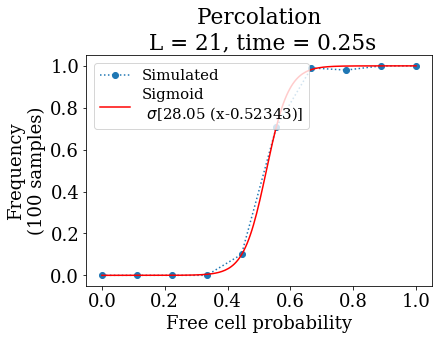

In [29]:
%%time
runover_main(21,100,10,'A',True,False)

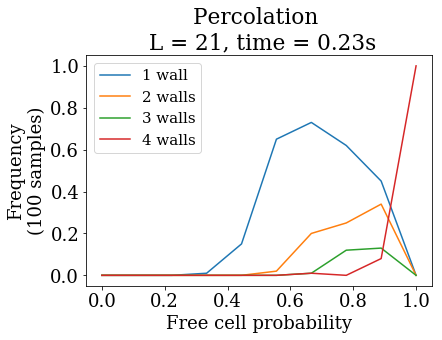

In [30]:
runover_main(21,100,10,'D',False,True)

In [31]:
import scipy.misc
def fractal_dimension(Z, threshold=0.9):
    #From https://gist.github.com/viveksck/1110dfca01e4ec2c608515f0d5a5b1d1

    # Only for 2d image
    assert(len(Z.shape) == 2)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])


    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

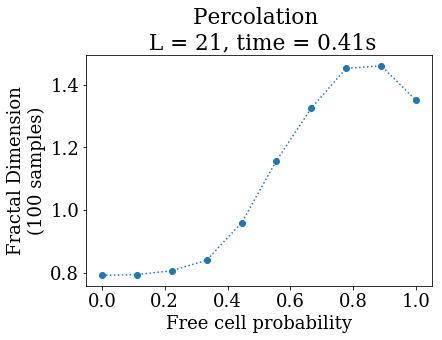

In [32]:
runover_main(21,100,10,'E',False,True)

In [36]:
def just_do_it():
    
    L_range = ([11,21,31])
    T_values = []
    
    for L in L_range:
        T_values.append(runover_main(L,1000,10,'A',True,False)) 

    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.plot(L_range,T_values,marker='o',ls=':')
    ax.set_xlabel('Grid size (L)')
    ax.set_ylabel('Run time (s)')

    print(L_range)
    print(T_values)
    return

[11, 21, 31]
[1.2848122119903564, 2.2149977684020996, 3.4171299934387207]


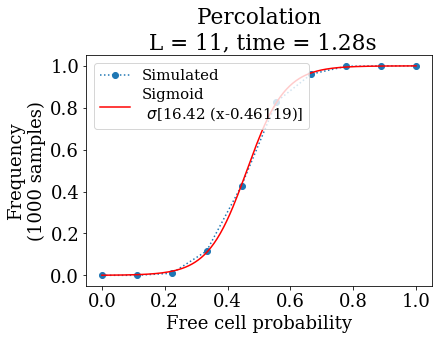

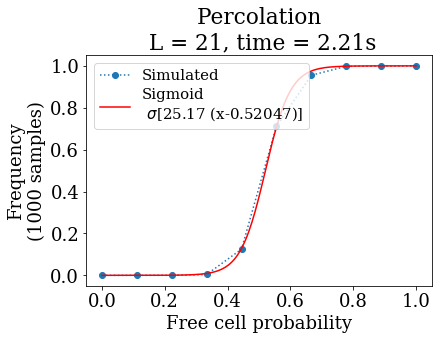

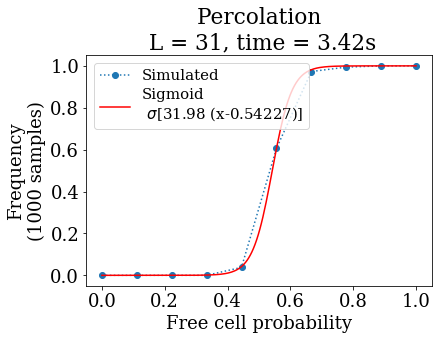

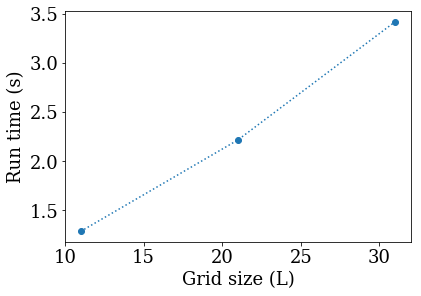

In [37]:
just_do_it()